In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ase.io import read
from ase import Atoms

from abtem import *
from abtem.waves import PlaneWave

import os
os.environ["MKL_NUM_THREADS"] = "1"

# Effect of temperature with frozen phonons

The atoms in any real material at a particular instance of time are not exactly located at their symmetrical lattice points due to thermal and zero-point vibrations. The frozen phonon approximation is a simple if somewhat brute-force approach to numerically simulate the effects of thermal vibrations in the specimen. In the Frozen phonon approximation, the simulated image or diffraction pattern is the intensity averaged over several different configurations of atoms with different random offsets. This type of scattering may be referred to as thermal diffuse scattering or simply TDS.

We will simulate strontium titanate [100] with TDS. In order to observe visible Kikuchi lines, the sample needs a certain thickness, hence we repeat the unit cell 40 times along the z-direction.

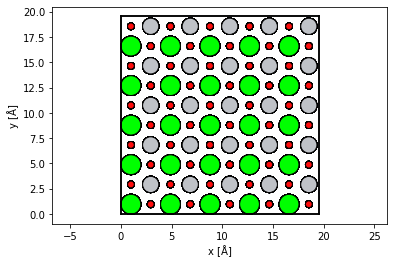

In [2]:
atoms = read('data/srtio3_100.cif')

atoms *= (5, 5, 80)

atoms.center()

show_atoms(atoms);

The `FrozenPhonon` class generates offsets from a Gaussian distribution (equivalent to the Einstein model of the density of states for phonons) using a random number generator with a given seed. The standard deviation of the Gaussian distribution is provided for each element as a dictionary.

In [3]:
frozen_phonons = FrozenPhonons(atoms, 12, {'Sr' : .1, 'Ti' : .1, 'O' : .1}, seed=1)

We can get out one of frozen phonon configurations by iterating the `FrozenPhonons` class.

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

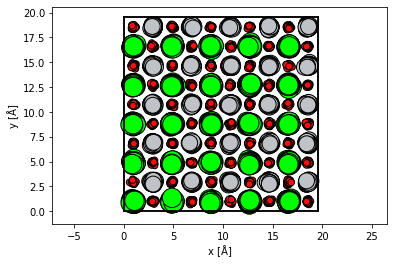

In [4]:
atoms_conf = frozen_phonons[0]

show_atoms(atoms_conf)

The `FrozenPhonons` class is given as argument instead of the atoms object. The potential now represents an ensemble of potentials with slightly displaced atomic configurations. We use the `infinite` projection scheme to speed up the calculation.

In [8]:
potential = Potential(frozen_phonons, gpts=512, slice_thickness=2, projection='infinite')

We can run a multislice simulation for an incoming plane wave of 300 keV energy just as without the frozen phonons, with one distinction.

In [11]:
exit_waves = PlaneWave(energy=300e3).multislice(potential, lazy=True)

The output is a stack of 12 exit waves, one for each potential in the frozen phonon ensemble.

In [12]:
exit_waves.array

dask.array<stack, shape=(12, 512, 512), dtype=complex64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>

We show the intensity of the one of the exit waves and the average intensity of the thermal ensemble.

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x179f6d11c10>)

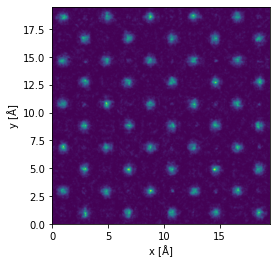

In [13]:
exit_waves[0].show()

[########################################] | 100% Completed | 15.4s


Text(0.5, 1.0, 'Thermal ensemble')

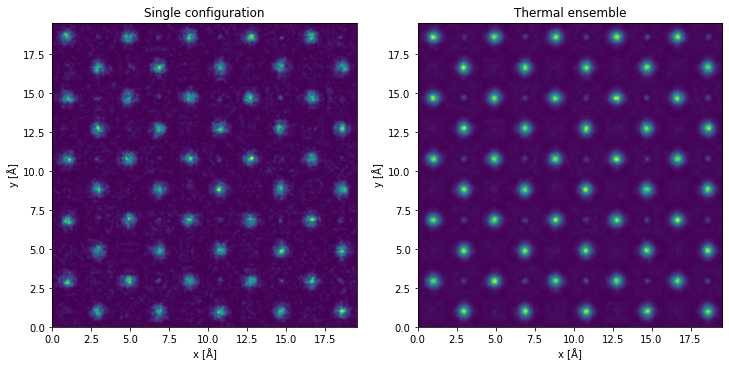

In [14]:
exit_waves.compute()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

exit_waves[0].show(ax = ax1)
ax1.set_title('Single configuration')
exit_waves.intensity().mean(0).show(ax = ax2)
ax2.set_title('Thermal ensemble')

We can apply a contrast transfer to the stack of exit waves, then take the mean of the intensity to get a more realistic image.

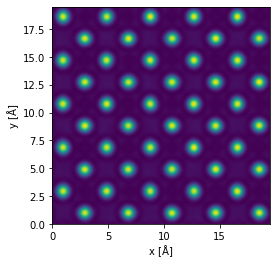

In [15]:
image_waves = exit_waves.apply_ctf(defocus=-45.47, Cs = -7e-6 * 1e10, focal_spread=50)

image_waves.intensity().mean(0).show();

We take the mean of the diffraction patterns to get the final diffraction pattern.

[########################################] | 100% Completed |  0.1s


(-100.0, 100.0)

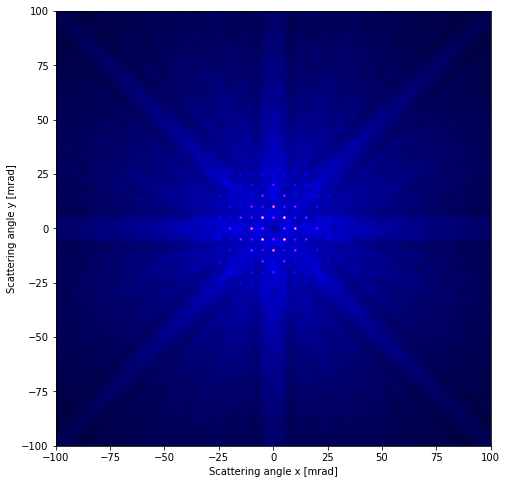

In [19]:
patterns = exit_waves.diffraction_patterns('valid', block_direct=True)

fig, ax = plt.subplots(1, 1, figsize=(8,8))

patterns.mean(0).show(ax=ax, cmap='gnuplot2', power=.2);

ax.set_xlim((-100,100))
ax.set_ylim((-100,100))


## STEM with TDS

Simulating STEM with TDS is not much different from what we have shown so far. We will simulate the same graphene image as we did earlier, now including TDS. We start by importing the necessary objects.

In [20]:
atoms = read('data/orthogonal_graphene.cif')

probe = Probe(energy=80e3, semiangle_cutoff=30, focal_spread=60, defocus=50)

linescan = LineScan(start=[2 * np.sqrt(3) * 1.42, 0], end=[2 * np.sqrt(3) * 1.42, 3 * 1.42], gpts=40, endpoint=False)

haadf = AnnularDetector(inner=90, outer=180)

We set up the TDS potential as above.

In [21]:
frozen_phonons = FrozenPhonons(atoms, 32, {'C' : .1}, seed=10)

tds_potential = Potential(frozen_phonons, sampling=.025, slice_thickness=2)

no_tds_potential = Potential(atoms, sampling=.025, slice_thickness=2)

Then we run the simulation.

In [22]:
tds_measurement = probe.scan(linescan, haadf, tds_potential)

[########################################] | 100% Completed |  4.6s


In [23]:
no_tds_measurement = probe.scan(linescan, haadf, no_tds_potential)

[########################################] | 100% Completed |  0.6s


We compare the simulation with TDS, to the one without. We see that TDS tends to increase high-angle scattering. In this case, the difference is quite modset, but it would be much more pronounced for a thicker sample. We also see that the line with TDS is assymetric, and thus clearly we would need to increase the number of frozen phonon configurations.

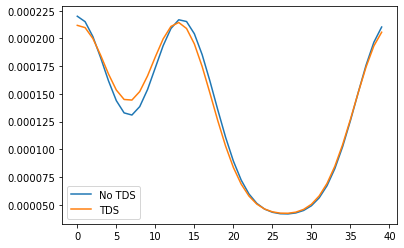

In [24]:
fig, ax = plt.subplots(1, 1)

no_tds_measurement.show(ax=ax, label='No TDS')
tds_measurement.show(ax=ax, label='TDS')

ax.legend()